In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
from utils import get_idle_proportion
import plotly.subplots as sp
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_saving_results = Path('./results')


# read data from the cleaning note book
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_cleaned.parquet.gzip')
df.head(n=5)

node                time  state
0  fcn1 2024-11-04 17:03:13  mixed
0  fcn1 2024-11-04 17:03:43  mixed
0  fcn1 2024-11-04 17:04:13  mixed
0  fcn1 2024-11-04 17:04:43  mixed
0  fcn1 2024-11-04 17:05:13  mixed

In [3]:
""" 
Add some useful signals:
NO MISTAKE should happen here. 
"""

# add the node type and get the regular nodes only
df['node_type'] = df['node'].str[0:3]
df = df[df['node_type'].isin(['fcn', 'gcn', 'tcn', 'hcn'])].copy()

# put the time in an interval: if time is in [start-end], we add a tag as start
df['time_30min_interval'] = (df['time']).dt.floor(freq='30min')
df['time_1hour_interval'] = (df['time']).dt.floor(freq='1h')
df['time_2hour_interval'] = (df['time']).dt.floor(freq='2h')
df['time_3hour_interval'] = (df['time']).dt.floor(freq='3h')
df['time_6hour_interval'] = (df['time']).dt.floor(freq='6h')
df['time_12hour_interval'] = (df['time']).dt.floor(freq='12h')
df['time_day_interval'] = (df['time']).dt.floor(freq='d')


# # how long a state last?
# df['duration'] = df.groupby('node')['time'].diff(1).shift(-1)
# # drop the rows that beccome Nan due to shift
# df = df[~(df['duration'].isna())]


# display a sample
N = len(df)//20
display(df.iloc[N: N + 5, :])


# save the data for the machine learning norte book.
# df.to_parquet(folder_path_slurm_data/'sinfo_EDA_cleaned.parquet.gzip', compression='gzip')

node                time  state node_type time_30min_interval  \
3  fcn6 2024-11-20 22:49:15  mixed       fcn 2024-11-20 22:30:00   
3  fcn6 2024-11-20 22:50:51  mixed       fcn 2024-11-20 22:30:00   
3  fcn6 2024-11-20 22:51:06  mixed       fcn 2024-11-20 22:30:00   
3  fcn6 2024-11-20 22:52:15  mixed       fcn 2024-11-20 22:30:00   
3  fcn6 2024-11-20 22:53:06  mixed       fcn 2024-11-20 22:30:00   

  time_1hour_interval time_2hour_interval time_3hour_interval  \
3 2024-11-20 22:00:00 2024-11-20 22:00:00 2024-11-20 21:00:00   
3 2024-11-20 22:00:00 2024-11-20 22:00:00 2024-11-20 21:00:00   
3 2024-11-20 22:00:00 2024-11-20 22:00:00 2024-11-20 21:00:00   
3 2024-11-20 22:00:00 2024-11-20 22:00:00 2024-11-20 21:00:00   
3 2024-11-20 22:00:00 2024-11-20 22:00:00 2024-11-20 21:00:00   

  time_6hour_interval time_12hour_interval time_day_interval  
3 2024-11-20 18:00:00  2024-11-20 12:00:00        2024-11-20  
3 2024-11-20 18:00:00  2024-11-20 12:00:00        2024-11-20  
3 2024-11-20 18:00:00  2024-11-20 12:00:00        2024-11-20  
3 2024-11-20 18:00:00  2024-11-20 12:00:00        2024-11-20  
3 2024-11-20 18:00:00  2024-11-20 12:00:00        2024-11-20

In [4]:
""" 
Pick a time interval to do the rest of the analysis
later we put all the codes in a function so we can always change the time_col
easily
NO MISTAKE SHOULD HAPPEN HERE. 
"""
time_col = 'time_6hour_interval' # from here until the moment we get the dataframe for plotting, put it in a function
# take a copy
df_with_duration = df.copy()
# how long does a state last? we are ignoreing those samples outside of the time interval. Does this make sense? Do I do it correclty?
df_with_duration['state_duration'] = df_with_duration.groupby(['node', time_col])['time'].diff(1).shift(-1)
# drop the rows that beccome Nan due to shift
df_with_duration = df_with_duration[~(df_with_duration['state_duration'].isna())]
# show me a sample and tell me as a sanity check what is the maximum duration? It should be lower than time interval
N = len(df_with_duration)//10
display(df_with_duration.iloc[N: N + 6, :], df_with_duration['state_duration'].describe(percentiles=[0.999]))
"""  
Here we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.
But 99.9 percent of the states takes around 5 minutes.
"""

node                time state node_type time_30min_interval  \
26  gcn130 2024-11-18 13:29:31  idle       gcn 2024-11-18 13:00:00   
26  gcn130 2024-11-18 13:31:31  idle       gcn 2024-11-18 13:30:00   
26  gcn130 2024-11-18 13:31:33  idle       gcn 2024-11-18 13:30:00   
26  gcn130 2024-11-18 13:31:57  idle       gcn 2024-11-18 13:30:00   
25  gcn130 2024-11-18 13:33:32  idle       gcn 2024-11-18 13:30:00   
25  gcn130 2024-11-18 13:34:33  idle       gcn 2024-11-18 13:30:00   

   time_1hour_interval time_2hour_interval time_3hour_interval  \
26 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   
26 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   
26 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   
26 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   
25 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   
25 2024-11-18 13:00:00 2024-11-18 12:00:00 2024-11-18 12:00:00   

   time_6hour_interval time_12hour_interval time_day_interval  state_duration  
26 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:02:00  
26 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:00:02  
26 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:00:24  
26 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:01:35  
25 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:01:01  
25 2024-11-18 12:00:00  2024-11-18 12:00:00        2024-11-18 0 days 00:00:24

count                     60371114
mean     0 days 00:00:40.831885460
std      0 days 00:00:33.320339649
min                0 days 00:00:01
50%                0 days 00:00:30
99.9%              0 days 00:02:21
max                0 days 01:16:38
Name: state_duration, dtype: object

'  \nHere we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.\nBut 99.9 percent of the states takes around 5 minutes.\n'

In [5]:
"""  
No mistake should happen here.
"""
# compute the total time a node was in a state in a given inteval
df_temp = df_with_duration.groupby(['node', time_col, 'state' ], as_index=False)[['state_duration']].sum()
df_temp.sort_values(['node', time_col], inplace=True)
df_temp.rename(columns={'state_duration':'state_duration_in_interval'}, inplace=True)


# show a smaple
N = len(df_temp)//10
display(df_temp.iloc[N-4: N + 10, :], "The maximum duration for a node in a state is:",df_temp['state_duration_in_interval'].max())
# note it is ok to get maximum duration smaller than the time interval
# we can change this behavior by doing the diff the way we did in the previous cell

node time_6hour_interval       state state_duration_in_interval
19526  gcn14 2024-11-16 06:00:00   allocated            0 days 04:45:29
19527  gcn14 2024-11-16 06:00:00  completing            0 days 00:02:00
19528  gcn14 2024-11-16 06:00:00        idle            0 days 00:52:05
19529  gcn14 2024-11-16 06:00:00       mixed            0 days 00:12:02
19530  gcn14 2024-11-16 06:00:00     planned            0 days 00:08:00
19531  gcn14 2024-11-16 12:00:00   allocated            0 days 03:04:17
19532  gcn14 2024-11-16 12:00:00  completing            0 days 00:03:00
19533  gcn14 2024-11-16 12:00:00       mixed            0 days 02:43:29
19534  gcn14 2024-11-16 12:00:00     planned            0 days 00:08:02
19535  gcn14 2024-11-16 18:00:00   allocated            0 days 00:36:14
19536  gcn14 2024-11-16 18:00:00       mixed            0 days 05:22:51
19537  gcn14 2024-11-17 00:00:00  completing            0 days 00:01:00
19538  gcn14 2024-11-17 00:00:00       mixed            0 days 05:56:30
19539  gcn14 2024-11-17 06:00:00  completing            0 days 00:00:12

'The maximum duration for a node in a state is:'

Timedelta('0 days 05:59:53')

In [6]:

"""  
No mistake here as well, crucial for later usages.
"""

# get the total time for all the states
df_total = df_temp.groupby(['node', time_col], as_index=False)['state_duration_in_interval'].sum().copy()
df_total.rename(columns={'state_duration_in_interval':'all_state_durations_in_interval'}, inplace=True)

# get the idle time for the states
df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'state_duration_in_interval':'idle_duration'}, inplace=True)

# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_total, how='outer', on=['node', time_col])
df_stat.fillna(value=pd.Timedelta('0s'), inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)

# divide the total idle duration in the interval by the total time of all the states: 
# we get proportion of the time that idle happened in the interval
df_stat['idle_proportion'] = (df_stat['idle_duration'] / df_stat['all_state_durations_in_interval'])



# show the data frame that we have
display(df_total.tail(n=10), df_idle.tail(n=10), df_stat.tail(n=10))

node time_6hour_interval all_state_durations_in_interval
116878  tcn999 2024-11-21 00:00:00                 0 days 05:58:33
116879  tcn999 2024-11-21 06:00:00                 0 days 05:58:36
116880  tcn999 2024-11-21 12:00:00                 0 days 05:58:36
116881  tcn999 2024-11-21 18:00:00                 0 days 05:58:57
116882  tcn999 2024-11-22 00:00:00                 0 days 05:58:28
116883  tcn999 2024-11-22 06:00:00                 0 days 05:59:16
116884  tcn999 2024-11-22 12:00:00                 0 days 05:58:50
116885  tcn999 2024-11-22 18:00:00                 0 days 05:58:44
116886  tcn999 2024-11-23 00:00:00                 0 days 05:58:31
116887  tcn999 2024-11-23 06:00:00                 0 days 01:34:09

node time_6hour_interval   idle_duration
195264  tcn999 2024-11-18 06:00:00 0 days 05:58:33
195266  tcn999 2024-11-18 12:00:00 0 days 05:05:55
195270  tcn999 2024-11-18 18:00:00 0 days 01:05:30
195272  tcn999 2024-11-19 00:00:00 0 days 05:58:54
195273  tcn999 2024-11-19 06:00:00 0 days 05:58:37
195276  tcn999 2024-11-19 12:00:00 0 days 04:25:57
195280  tcn999 2024-11-19 18:00:00 0 days 04:36:07
195282  tcn999 2024-11-20 00:00:00 0 days 05:58:52
195285  tcn999 2024-11-20 06:00:00 0 days 05:19:55
195289  tcn999 2024-11-20 12:00:00 0 days 03:38:08

node time_6hour_interval idle_duration  \
116878  tcn999 2024-11-21 00:00:00        0 days   
116879  tcn999 2024-11-21 06:00:00        0 days   
116880  tcn999 2024-11-21 12:00:00        0 days   
116881  tcn999 2024-11-21 18:00:00        0 days   
116882  tcn999 2024-11-22 00:00:00        0 days   
116883  tcn999 2024-11-22 06:00:00        0 days   
116884  tcn999 2024-11-22 12:00:00        0 days   
116885  tcn999 2024-11-22 18:00:00        0 days   
116886  tcn999 2024-11-23 00:00:00        0 days   
116887  tcn999 2024-11-23 06:00:00        0 days   

       all_state_durations_in_interval  idle_proportion  
116878                 0 days 05:58:33              0.0  
116879                 0 days 05:58:36              0.0  
116880                 0 days 05:58:36              0.0  
116881                 0 days 05:58:57              0.0  
116882                 0 days 05:58:28              0.0  
116883                 0 days 05:59:16              0.0  
116884                 0 days 05:58:50              0.0  
116885                 0 days 05:58:44              0.0  
116886                 0 days 05:58:31              0.0  
116887                 0 days 01:34:09              0.0

In [7]:

# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_12hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
display(df_total.head(), df_idle.head(), df_stat.head())



# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
display(df_stat_pivot.head())

node time_12hour_interval all_state_durations_in_interval
0  fcn1  2024-11-04 12:00:00                 0 days 06:56:30
1  fcn1  2024-11-05 00:00:00                 0 days 11:59:20
2  fcn1  2024-11-05 12:00:00                 0 days 11:59:55
3  fcn1  2024-11-06 00:00:00                 0 days 11:59:19
4  fcn1  2024-11-06 12:00:00                 0 days 11:59:39

node time_12hour_interval   idle_duration
13  fcn1  2024-11-09 00:00:00 0 days 02:59:30
15  fcn1  2024-11-09 12:00:00 0 days 11:59:40
16  fcn1  2024-11-10 00:00:00 0 days 11:59:03
18  fcn1  2024-11-10 12:00:00 0 days 09:23:07
23  fcn1  2024-11-11 12:00:00 0 days 01:13:04

node time_12hour_interval idle_duration all_state_durations_in_interval  \
0  fcn1  2024-11-04 12:00:00        0 days                 0 days 06:56:30   
1  fcn1  2024-11-05 00:00:00        0 days                 0 days 11:59:20   
2  fcn1  2024-11-05 12:00:00        0 days                 0 days 11:59:55   
3  fcn1  2024-11-06 00:00:00        0 days                 0 days 11:59:19   
4  fcn1  2024-11-06 12:00:00        0 days                 0 days 11:59:39   

   idle_proportion  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

node                  fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_12hour_interval                                                         
2024-11-04 12:00       0.0  0.0240     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00       0.0  0.7226     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00       0.0  0.3128     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00       0.0  0.6942     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00       0.0  0.6308     1.0     1.0     1.0     1.0     1.0   

node                  fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0  0.0000     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0  0.4467     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0  0.3567     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0  0.8704     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0  0.7890     1.0   

node                  fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   

node                  fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0  0.0240     1.0  0.0240  0.0000  0.0240   
2024-11-05 00:00         1.0     1.0  0.2759     1.0  0.7019  0.0000  0.7192   
2024-11-05 12:00         1.0     1.0  0.6519     1.0  0.2441  0.0000  0.7171   
2024-11-06 00:00         1.0     1.0  0.6669     1.0  0.8746  0.0293  0.8815   
2024-11-06 12:00         1.0     1.0  0.0000     1.0  0.4929  0.7785  0.2850   

node                   fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0240  0.0240  0.9938  0.0012  0.0240  0.0240   
2024-11-05 00:00      0.7633  0.7178  0.7313  1.0000  0.0000  0.7313  0.7313   
2024-11-05 12:00      0.0899  0.0913  0.9094  1.0000  0.0000  0.9115  0.9115   
2024-11-06 00:00      0.1874  0.1972  0.9610  1.0000  0.1609  0.9610  0.9749   
2024-11-06 12:00      0.8565  0.8537  0.8537  0.9958  0.0000  0.8544  0.8175   

node                   fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0240  0.0240  0.0240  0.9938  0.0240  0.0240  0.0240   
2024-11-05 00:00      0.7313  0.7313  0.7313  1.0000  0.0000  0.4105  0.7313   
2024-11-05 12:00      0.7260  0.9652  1.0000  1.0000  0.8967  1.0000  1.0000   
2024-11-06 00:00      0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.0000  0.8168  0.8168  0.9951  0.8217  0.8203  0.8461   

node                   fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0000  0.0240  0.0240  0.0253  0.0240  0.0240   
2024-11-05 00:00      0.0000  0.0000  0.7313  0.6345  0.4456  0.3052  0.7313   
2024-11-05 12:00      0.9045  0.0335  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 00:00      1.0000  0.6012  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.8488  0.5772  0.8642  0.8537  0.8356  0.8251  0.8140   

node                   fcn35   fcn36   fcn37   fcn38   fcn39  fcn4   fcn40  \
time_12ho

In [ ]:
# plotting

# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]

titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]


map_time_column_names = {"time_30min_interval": "30 minutes interval",
                         "time_1hour_interval": "1 hour interval",
                         "time_3hour_interval": "3 hours interval",
                         "time_6hour_interval": "6 hours interval",
                         "time_12hour_interval": "12 hours inteval",
                         "time_day_interval": "1 day interval"
                             }

# Create a subplot figure with 8 rows, 1 column
fig = sp.make_subplots(
    rows=8, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.025
)

# Loop through each axis and range, adding heatmaps with a title for each
for i, (start, end) in enumerate(ranges):
    # Select the range of columns to plot
    sub_df = df_stat_pivot.iloc[:, start:end]
    
    # Add the heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=sub_df.values,
            x=sub_df.columns,
            y=sub_df.index,
            # colorscale='blackbody',
            # colorscale='electric',
                        colorscale='hot',
                # colorscale='inferno',


            zmin=0,
            zmax=1,
            colorbar=dict(
                title='Idle Fraction',
                orientation='v',
                len=0.25,  # Adjust length of colorbars
                yanchor='top',
                y=1 ,  # Offset to position the colorbar correctly
            ),
        ),
        row=i+1, col=1
    )


    # Ensure all ticks are displayed
    fig.update_xaxes(
        tickmode="array",
        tickvals=sub_df.columns.tolist(),
        ticktext=sub_df.columns.tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
    fig.update_yaxes(
        tickmode="array",
        tickvals=sub_df.index.tolist(),
        ticktext=sub_df.index.str[5:16].tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
# Update the layout for better appearance
fig.update_layout(
    height=2600,  # Adjust height of the figure
    width=1400,  # Adjust width of the figure
    title=f"Nodes Idle Partition - {map_time_column_names[time_col]}",
    title_x=0.5,
    showlegend=False
)

output_path_pdf = folder_path_saving_results / f"nodes_idle_partition_{time_col}.pdf"
output_path_png = folder_path_saving_results / f"nodes_idle_partition_{time_col}.png"
fig.write_image(output_path_pdf)
fig.write_image(output_path_png, scale=2)

# Show the interactive heatmap
fig.show()


# move the figures to the laptop for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .



In [9]:

"""  
sort the data form high to low occupied nodes
"""
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()
df_sorted_nodes.head()

node                  tcn703  tcn1174  tcn1177  tcn1176  tcn535  tcn288  \
time_12hour_interval                                                      
2024-11-04 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-05 00:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-05 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-06 00:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-06 12:00         0.0      0.0      0.0      0.0     0.0     0.0   

node                  tcn702  gcn4  tcn179  tcn510  tcn523  gcn48  gcn94  \
time_12hour_interval                                                       
2024-11-04 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-05 00:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-05 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-06 00:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-06 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   

node                  tcn557  tcn559  tcn321  gcn80  gcn85  gcn86  gcn91  \
time_12hour_interval                                                       
2024-11-04 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   

node                  gcn87  gcn90  gcn89  gcn88  gcn82  gcn81  gcn79  gcn83  \
time_12hour_interval                                                           
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn76  gcn77  gcn78  gcn71  gcn84  gcn93  gcn92  gcn75  \
time_12hour_interval                                                           
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn74  tcn88  tcn1178  tcn1184  tcn1189  gcn28  gcn7  \
time_12hour_interval                                                         
2024-11-04 12:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   
2024-11-05 00:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   
2024-11-05 12:00        0.0    0.0      0.0   0.0021   0.0000    0.0   0.0   
2024-11-06 00:00        0.0    0.0      0.0   0.0000   0.0007    0.0   0.0   
2024-11-06 12:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   

node                  tcn1186  tcn1187  tcn1182  tcn1185  tcn1191  tcn1180  \
time_12hour_interval                                                         
2024-11-04 12:00          0.0   0.0228   0.0024      0.0   0.0000      0.0   
2024-11-05 00:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   
2024-11-05 12:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   
2024-11-06 00:00          0.0   0.0000   0.0000      0.0   0.0341      0.0   
2024-11-06 12:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   

node                  tcn1175  tcn1181  tcn413  tcn1188  tcn327  gcn2  tcn326  \
time_12hour_interval                                                            
2024-11-04 12:00          0.0 

In [ ]:
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Create a subplot figure with 8 rows, 1 column
fig = sp.make_subplots(
    rows=8, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.025
)

# Loop through each axis and range, adding heatmaps with a title for each
for i, (start, end) in enumerate(ranges):
    # Select the range of columns to plot
    sub_df = df_sorted_nodes.iloc[:, start:end]
    
    # Add the heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=sub_df.values,
            x=sub_df.columns,
            y=sub_df.index,
            # colorscale='blackbody',
            # colorscale='electric',
                        colorscale='hot',
                # colorscale='inferno',


            zmin=0,
            zmax=1,
            colorbar=dict(
                title='Idle Fraction',
                orientation='v',
                len=0.25,  # Adjust length of colorbars
                yanchor='top',
                y=1 ,  # Offset to position the colorbar correctly
            ),
        ),
        row=i+1, col=1
    )


    # Ensure all ticks are displayed
    fig.update_xaxes(
        tickmode="array",
        tickvals=sub_df.columns.tolist(),
        ticktext=sub_df.columns.tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
    fig.update_yaxes(
        tickmode="array",
        tickvals=sub_df.index.tolist(),
        ticktext=sub_df.index.str[5:16].tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
# Update the layout for better appearance
fig.update_layout(
    height=2600,  # Adjust height of the figure
    width=1400,  # Adjust width of the figure
    title=f"Low to high idle nodes - {map_time_column_names[time_col]}",
    title_x=0.5,
    showlegend=False
)

# Save the figure
output_path_pdf = folder_path_saving_results / f"nodes_idle_ranked_{time_col}.pdf"
output_path_png = folder_path_saving_results / f"nodes_idle_ranked_{time_col}.png"
fig.write_image(output_path_pdf)
fig.write_image(output_path_png, scale=2)

# Show the interactive heatmap
fig.show()

In [11]:
"""  
IS THERE ANY HOURLY PATTERN IN THE DATA?

"""


# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_12hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)

# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")


node_names_low_to_high_idle = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_nodes_low_to_high_idle = df_stat_pivot[node_names_low_to_high_idle].copy()

time_high_to_low = df_nodes_low_to_high_idle.sum(axis=1).sort_values(ascending=True).index


df_nodes_low_to_high_idle_sorted_time = df_nodes_low_to_high_idle.loc[time_high_to_low, :].copy()

display(df_stat_pivot.head(), df_nodes_low_to_high_idle.head(), df_nodes_low_to_high_idle_sorted_time.head())




node                  fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_12hour_interval                                                         
2024-11-04 12:00       0.0  0.0240     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00       0.0  0.7226     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00       0.0  0.3128     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00       0.0  0.6942     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00       0.0  0.6308     1.0     1.0     1.0     1.0     1.0   

node                  fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0  0.0000     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0  0.4467     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0  0.3567     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0  0.8704     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0  0.7890     1.0   

node                  fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   

node                  fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0  0.0240     1.0  0.0240  0.0000  0.0240   
2024-11-05 00:00         1.0     1.0  0.2759     1.0  0.7019  0.0000  0.7192   
2024-11-05 12:00         1.0     1.0  0.6519     1.0  0.2441  0.0000  0.7171   
2024-11-06 00:00         1.0     1.0  0.6669     1.0  0.8746  0.0293  0.8815   
2024-11-06 12:00         1.0     1.0  0.0000     1.0  0.4929  0.7785  0.2850   

node                   fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0240  0.0240  0.9938  0.0012  0.0240  0.0240   
2024-11-05 00:00      0.7633  0.7178  0.7313  1.0000  0.0000  0.7313  0.7313   
2024-11-05 12:00      0.0899  0.0913  0.9094  1.0000  0.0000  0.9115  0.9115   
2024-11-06 00:00      0.1874  0.1972  0.9610  1.0000  0.1609  0.9610  0.9749   
2024-11-06 12:00      0.8565  0.8537  0.8537  0.9958  0.0000  0.8544  0.8175   

node                   fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0240  0.0240  0.0240  0.9938  0.0240  0.0240  0.0240   
2024-11-05 00:00      0.7313  0.7313  0.7313  1.0000  0.0000  0.4105  0.7313   
2024-11-05 12:00      0.7260  0.9652  1.0000  1.0000  0.8967  1.0000  1.0000   
2024-11-06 00:00      0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.0000  0.8168  0.8168  0.9951  0.8217  0.8203  0.8461   

node                   fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0000  0.0240  0.0240  0.0253  0.0240  0.0240   
2024-11-05 00:00      0.0000  0.0000  0.7313  0.6345  0.4456  0.3052  0.7313   
2024-11-05 12:00      0.9045  0.0335  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 00:00      1.0000  0.6012  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.8488  0.5772  0.8642  0.8537  0.8356  0.8251  0.8140   

node                   fcn35   fcn36   fcn37   fcn38   fcn39  fcn4   fcn40  \
time_12ho

node                  tcn703  tcn1174  tcn1177  tcn1176  tcn535  tcn288  \
time_12hour_interval                                                      
2024-11-04 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-05 00:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-05 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-06 00:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-06 12:00         0.0      0.0      0.0      0.0     0.0     0.0   

node                  tcn702  gcn4  tcn179  tcn510  tcn523  gcn48  gcn94  \
time_12hour_interval                                                       
2024-11-04 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-05 00:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-05 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-06 00:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   
2024-11-06 12:00         0.0   0.0     0.0     0.0     0.0    0.0    0.0   

node                  tcn557  tcn559  tcn321  gcn80  gcn85  gcn86  gcn91  \
time_12hour_interval                                                       
2024-11-04 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00         0.0     0.0     0.0    0.0    0.0    0.0    0.0   

node                  gcn87  gcn90  gcn89  gcn88  gcn82  gcn81  gcn79  gcn83  \
time_12hour_interval                                                           
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn76  gcn77  gcn78  gcn71  gcn84  gcn93  gcn92  gcn75  \
time_12hour_interval                                                           
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn74  tcn88  tcn1178  tcn1184  tcn1189  gcn28  gcn7  \
time_12hour_interval                                                         
2024-11-04 12:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   
2024-11-05 00:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   
2024-11-05 12:00        0.0    0.0      0.0   0.0021   0.0000    0.0   0.0   
2024-11-06 00:00        0.0    0.0      0.0   0.0000   0.0007    0.0   0.0   
2024-11-06 12:00        0.0    0.0      0.0   0.0000   0.0000    0.0   0.0   

node                  tcn1186  tcn1187  tcn1182  tcn1185  tcn1191  tcn1180  \
time_12hour_interval                                                         
2024-11-04 12:00          0.0   0.0228   0.0024      0.0   0.0000      0.0   
2024-11-05 00:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   
2024-11-05 12:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   
2024-11-06 00:00          0.0   0.0000   0.0000      0.0   0.0341      0.0   
2024-11-06 12:00          0.0   0.0000   0.0000      0.0   0.0000      0.0   

node                  tcn1175  tcn1181  tcn413  tcn1188  tcn327  gcn2  tcn326  \
time_12hour_interval                                                            
2024-11-04 12:00          0.0 

node                  tcn703  tcn1174  tcn1177  tcn1176  tcn535  tcn288  \
time_12hour_interval                                                      
2024-11-14 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-15 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-11 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-12 12:00         0.0      0.0      0.0      0.0     0.0     0.0   
2024-11-12 00:00         0.0      0.0      0.0      0.0     0.0     0.0   

node                  tcn702  gcn4  tcn179  tcn510  tcn523   gcn48   gcn94  \
time_12hour_interval                                                         
2024-11-14 12:00         0.0   0.0     0.0  0.0000  0.0000  0.0000  0.0000   
2024-11-15 12:00         0.0   0.0     0.0  0.0000  0.0000  0.0000  0.0000   
2024-11-11 12:00         0.0   0.0     0.0  0.0000  0.0000  0.0000  0.0000   
2024-11-12 12:00         0.0   0.0     0.0  0.0011  0.0011  0.0011  0.0011   
2024-11-12 00:00         0.0   0.0     0.0  0.0000  0.0000  0.0000  0.0000   

node                  tcn557  tcn559  tcn321   gcn80   gcn85   gcn86   gcn91  \
time_12hour_interval                                                           
2024-11-14 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-15 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-11 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-12 12:00      0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0011   
2024-11-12 00:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

node                   gcn87   gcn90   gcn89   gcn88   gcn82   gcn81   gcn79  \
time_12hour_interval                                                           
2024-11-14 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-15 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-11 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-12 12:00      0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0011   
2024-11-12 00:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

node                   gcn83   gcn76   gcn77   gcn78   gcn71   gcn84   gcn93  \
time_12hour_interval                                                           
2024-11-14 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-15 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-11 12:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-12 12:00      0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0011   
2024-11-12 00:00      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

node                   gcn92   gcn75   gcn74   tcn88  tcn1178  tcn1184  \
time_12hour_interval                                                     
2024-11-14 12:00      0.0000  0.0000  0.0000  0.0000      0.0      0.0   
2024-11-15 12:00      0.0000  0.0000  0.0000  0.0000      0.0      0.0   
2024-11-11 12:00      0.0000  0.0000  0.0000  0.0000      0.0      0.0   
2024-11-12 12:00      0.0011  0.0011  0.0011  0.0011      0.0      0.0   
2024-11-12 00:00      0.0000  0.0000  0.0000  0.0000      0.0      0.0   

node                  tcn1189   gcn28    gcn7  tcn1186  tcn1187  tcn1182  \
time_12hour_interval                                                       
2024-11-14 12:00          0.0  0.0000  0.0000   0.0000      0.0   0.0000   
2024-11-15 12:00          0.0  0.0000  0.0000   0.0628      0.0   0.0000   
2024-11-11 12:00          0.0  0.0000  0.0000   0.0000      0.0   0.0760   
2024-11-12 12:00          0.0  0.0023  0.0000   0.0000      0.0   0.0000   
2024-11-12 00:00          0.0  0.0000  0.0028   0.0000      0.0   0.0028   

node                  tcn1185  tcn1191  tcn1180  tcn1175  tcn1181  tcn413  \
time_12hour_interval                                                        
2024-11-14 12:00       0.0000   0.0000

In [22]:
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Create a subplot figure with 8 rows, 1 column
fig = sp.make_subplots(
    rows=8, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.025
)

# Loop through each axis and range, adding heatmaps with a title for each
for i, (start, end) in enumerate(ranges):
    # Select the range of columns to plot
    sub_df = df_nodes_low_to_high_idle_sorted_time.iloc[:, start:end].copy()
    # display(sub_df.head())

    # Add the heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=sub_df.values,
            x=sub_df.columns,
            y=sub_df.index,
            # colorscale='blackbody',
            # colorscale='electric',
                        colorscale='hot',
                # colorscale='inferno',


            zmin=0,
            zmax=1,
            colorbar=dict(
                title='Idle Fraction',
                orientation='v',
                len=0.25,  # Adjust length of colorbars
                yanchor='top',
                y=1 ,  # Offset to position the colorbar correctly
            ),
        ),
        row=i+1, col=1
    )


    # Ensure all ticks are displayed
    fig.update_xaxes(
        tickmode="array",
        tickvals=sub_df.columns.tolist(),
        ticktext=sub_df.columns.tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
    fig.update_yaxes(
        tickmode="array",
        tickvals=sub_df.index.tolist(),
        ticktext=sub_df.index.str[5:16].tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
# Update the layout for better appearance
fig.update_layout(
    height=2600,  # Adjust height of the figure
    width=1400,  # Adjust width of the figure
    title=f"Low to high idle nodes and sorted idle time - {map_time_column_names[time_col]}",
    title_x=0.5,
    showlegend=False
)

# Save the figure
# output_path_pdf = folder_path_saving_results / f"nodes_idle_ranked_{time_col}.pdf"
# output_path_png = folder_path_saving_results / f"nodes_idle_ranked_{time_col}.png"
# fig.write_image(output_path_pdf)
# fig.write_image(output_path_png, scale=2)

# Show the interactive heatmap
fig.show()

In [13]:

"""  
DO WE HAVE MISSING VALUES? It is important to see if there is any missing value in our measurements.
We have to look at start and end time for all series.
Do they have the same length? Do they have the same frequency?
It seems that for larger time interval all the series have the same lenght, but for interval 
less than and equal to 2 hours some series have missing values. ==>> WHAT are these nodes? see next cell
"""
# select different time_interval: If we use the data with 1 hour inteval do we get any missing values?
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# find the min and max time and the number of samples for each node
df_stat_min_time_max_time = df_stat.groupby('node', as_index=False)[time_col].agg(['min', 'max', 'count'])
# find the measurement frequency for each node. Is it the same with time col?
df_stat_freq = df_stat.groupby('node')[time_col].diff(1).value_counts()
display(df_stat_min_time_max_time.sample(n=10), df_stat_min_time_max_time.describe(), df_stat_freq)

node                 min                 max  count
1511  tcn975 2024-11-04 17:00:00 2024-11-23 07:00:00    447
687   tcn230 2024-11-04 17:00:00 2024-11-23 07:00:00    447
1225  tcn717 2024-11-04 17:00:00 2024-11-23 07:00:00    447
1155  tcn654 2024-11-04 17:00:00 2024-11-23 07:00:00    447
929    tcn45 2024-11-04 17:00:00 2024-11-23 07:00:00    447
1314  tcn798 2024-11-04 17:00:00 2024-11-23 07:00:00    447
237    gcn63 2024-11-04 17:00:00 2024-11-23 07:00:00    447
201     gcn3 2024-11-04 17:00:00 2024-11-23 07:00:00    447
112    fcn92 2024-11-04 17:00:00 2024-11-23 07:00:00    447
791   tcn325 2024-11-04 17:00:00 2024-11-23 07:00:00    447

min                            max   count
count                 1538                           1538  1538.0
mean   2024-11-04 17:00:00  2024-11-23 06:59:59.999999744   447.0
min    2024-11-04 17:00:00            2024-11-23 07:00:00   447.0
25%    2024-11-04 17:00:00            2024-11-23 07:00:00   447.0
50%    2024-11-04 17:00:00            2024-11-23 07:00:00   447.0
75%    2024-11-04 17:00:00            2024-11-23 07:00:00   447.0
max    2024-11-04 17:00:00            2024-11-23 07:00:00   447.0
std                    NaN                            NaN     0.0

time_1hour_interval
0 days 01:00:00    685948
Name: count, dtype: int64

'  \nIt is very confusing why not all the nodes have missing values? Does this mean that the missing value\nis because of the fact that these nodes did not appear in sinfo or it was measurement error?\n'

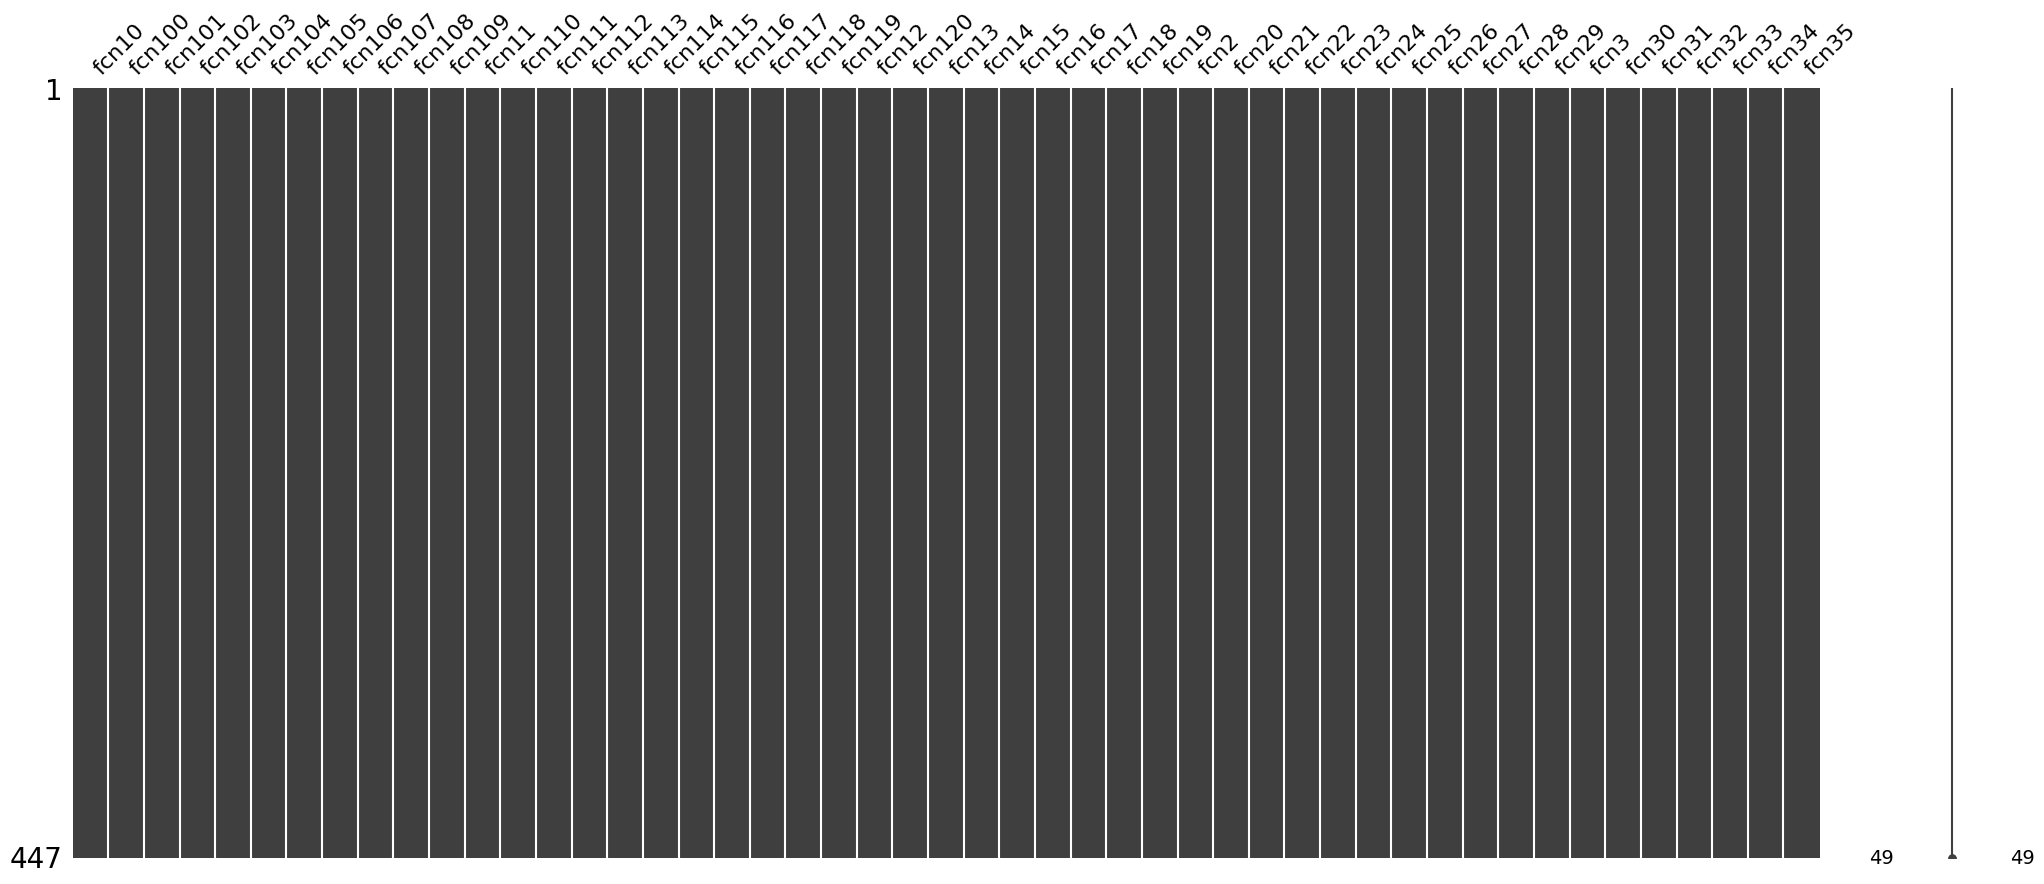

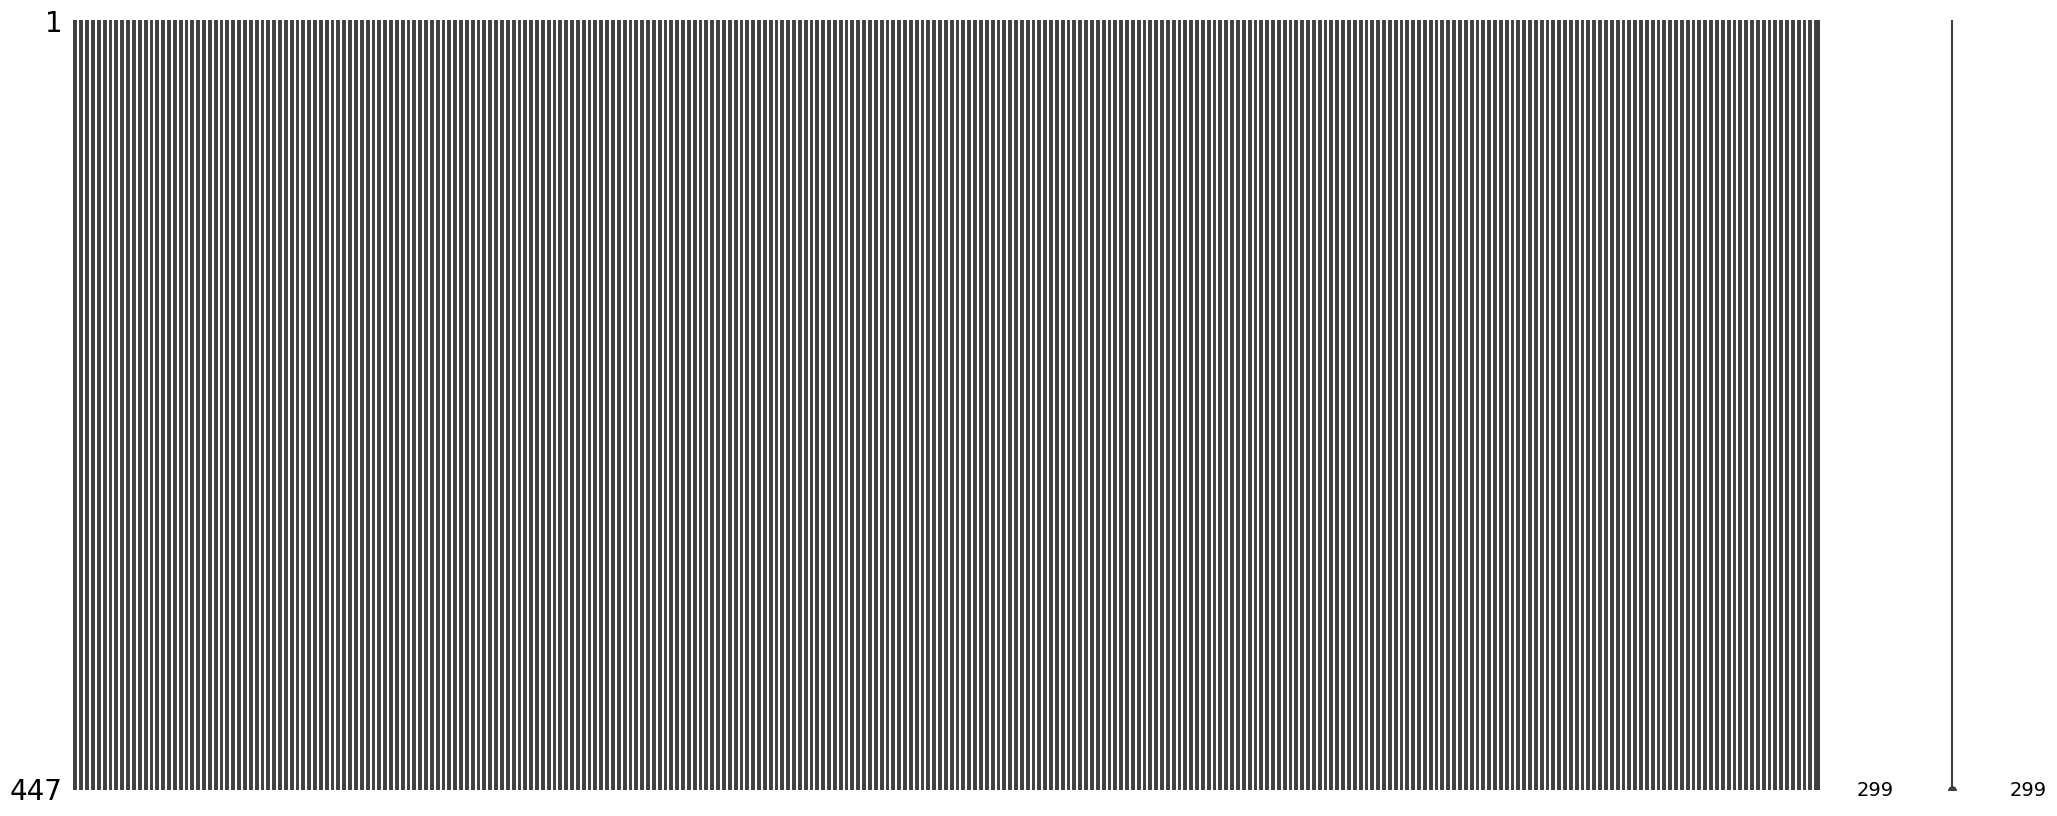

In [14]:
"""  
Show the some of the ndoes that have missing values
show the all the nodes that have missing values
The white spaces show the sample that is missing in the data for a  specific node.
"""
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")

node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_stat_pivot.iloc[:,1:50])
msno.matrix(df_sorted_nodes.iloc[:, 1:300])

"""  
It is very confusing why not all the nodes have missing values? Does this mean that the missing value
is because of the fact that these nodes did not appear in sinfo or it was measurement error?
"""







In [15]:
"""  
I like to see the seasnoality for the state.
It could be the pattern repeat it self:
hourly resolution ==> day plot
2 hourrly ==> day plot
.
.
.
12 hourly == weekly plot
"""


# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# get name of the day
df_stat['day'] = df_stat[time_col].dt.day_name()
# get hour of the day
df_stat['hour'] = df_stat[time_col].dt.hour
# do the adverage based on node and day and hour
df_temp = df_stat.groupby(['node', 'day', 'hour'], as_index=False)['idle_proportion'].mean()


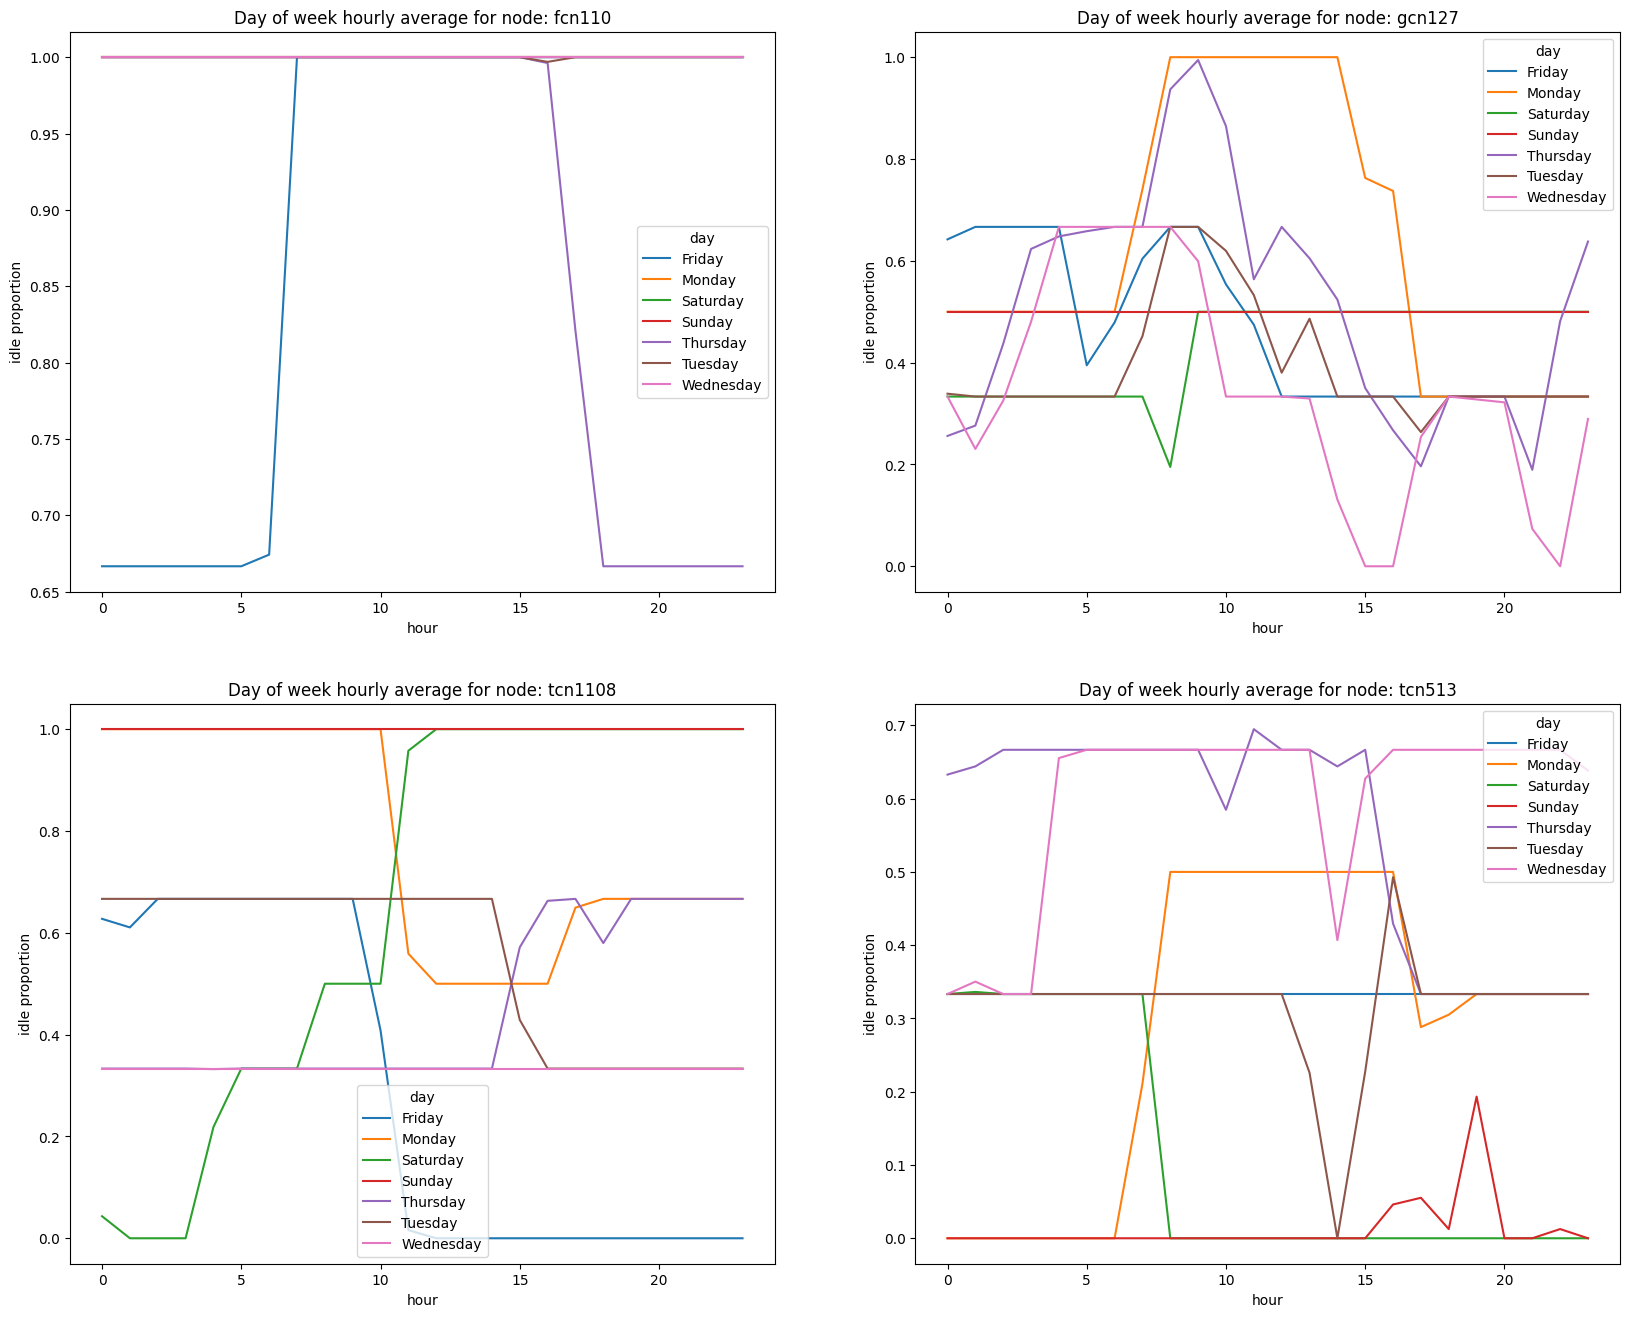

In [16]:
"""  
With getting more and more data I expect these plots to let us know
is there any seasnoality in the signal, e.g. during some hours of the day a node
is always busy ...
"""

# pick random number between 0:1550 for plotting
node_list = df_stat['node'].unique()[[13, 150, 400, 1000]]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
node_type_loc = { 1:ax[0,0], 2:ax[0,1], 3:ax[1,0], 4:ax[1,1]}

for i, node_name in enumerate(node_list):
    data = df_temp[df_temp['node']==node_name].copy()
    sns.lineplot(data, x='hour', y='idle_proportion', hue='day', ax=node_type_loc[i+1]) 
    node_type_loc[i+1].set_ylabel("idle proportion")
    # node_type_loc[node_type].set_xlabel("Node Waiting Time (minutes)")
    node_type_loc[i+1].set_title(f"Day of week hourly average for node: {node_name}")

plt.show()


